In [1]:
import os
import torch as T
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
from parallel_env import ParallelEnv,ParallelWrapper
from utils import test_policy_network,seed_everything,plot_stats

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

In [4]:
env.reset(),num_states,num_actions

(array([ 0.99974576,  0.022548  ,  0.99997744,  0.00671763, -0.09325952,
        -0.03716143]),
 6,
 3)

In [5]:
"""Number of parallel environments"""
num_envs = os.cpu_count()

In [6]:
num_envs

8

In [7]:
def create_env(env_name,seed):
    env = gym.make(env_name)
    seed_everything(env)
    return env

In [8]:
env_fns = [lambda: create_env('Acrobot-v1',seed=rank)for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

In [9]:
class PreprocessEnv(ParallelWrapper):
    def __init__(self,env):
        ParallelWrapper.__init__(self,env)
    def reset(self):
        state = self.venv.reset()
        return T.from_numpy(state).float()
    def step_async(self,actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
        
    def step_wait(self):
        next_state,reward,done,info = self.venv.step_wait()
        next_state = T.from_numpy(next_state).float()
        reward = T.tensor(reward).unsqueeze(1).float()
        done = T.tensor(done).unsqueeze(1)
        return next_state,reward,done,info

In [10]:
"""Creating parallel environments"""
parallel_env = PreprocessEnv(parallel_env)

In [11]:
"""The Policy Network"""
def PolicyNet(num_states,num_actions,fc1_dims=128,fc2_dims=64):
    policy = nn.Sequential(
        nn.Linear(num_states,fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims,fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims,num_actions),
        nn.Softmax(dim=-1))
    return policy
    

In [12]:
"""The Value Network"""
def ValueNet(num_states,num_actions,fc1_dims=128,fc2_dims = 64):
    value = nn.Sequential(
        nn.Linear(num_states,fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims,fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims,1))
    return value

In [21]:
"""The main function which implements the A2C algorithm"""
def A2C(PolicyNet,ValueNet,epochs,num_states,num_actions,
        alpha=1e-4,gamma=0.99,fc1_dims=128,fc2_dims = 64):
    policy_net = PolicyNet(num_states,num_actions,fc1_dims,fc2_dims)
    value_net = ValueNet(num_states,num_actions,fc1_dims,fc2_dims)
    policy_optim = AdamW(policy_net.parameters(),lr = alpha)
    value_optim = AdamW(value_net.parameters(), lr = alpha)
    stats = {'Actor Loss': [],'Critic Loss': [],'Returns': []}
    
    for epoch in tqdm(range(1,epochs+1)):
        state = parallel_env.reset()
        done_b = T.zeros((num_envs,1),dtype = T.bool)
        ep_return = T.zeros((num_envs,1))
        I = 1.
        while not done_b.all():
            action = policy_net(state).multinomial(1).detach()
            next_state,reward,done,_ = parallel_env.step(action)
            value = value_net(state)
            target = reward + ~done*gamma*value_net(next_state).detach()
            critic_loss = F.mse_loss(value,target)
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()
            
            advantage = (target -value).detach()
            probs = policy_net(state)
            log_probs = T.log(probs+1e-6)
            action_log_prob = log_probs.gather(1,action)
            entropy = -T.sum(probs*log_probs,dim=-1,keepdim=True)
            actor_loss = -I*action_log_prob*advantage-0.01*entropy
            actor_loss = actor_loss.mean()
            policy_net.zero_grad()
            actor_loss.backward()
            policy_optim.step()
            
            ep_return  += reward
            done_b |= done
            state = next_state
            I = I*gamma
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
    return stats

In [22]:
stats = A2C(PolicyNet,ValueNet,200,num_states,num_actions)

100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


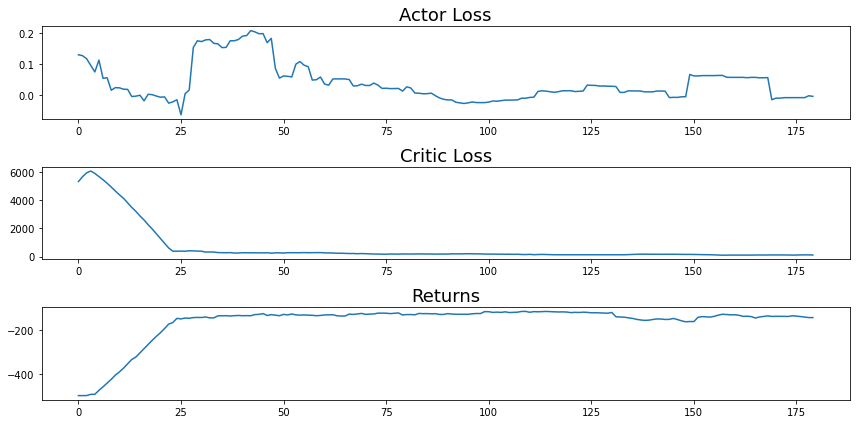

In [25]:
plot_stats(stats)